## 本家のDU-GD-LMSとDU-GD-LMS2のどちらもこのノートブックに書く

In [2]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [3]:
n = 50
m = 100
num_itr = 50
K = 100
adam_lr = 1e-4
max_inner = 40

In [4]:
A = np.random.randn(m,n)
Pinv = LA.pinv(A)
eig, _ = LA.eig(A.T @ A)
lambda_min = min(eig)
lambda_max = max(eig)
eta_opt = 2/(lambda_min + lambda_max)

In [5]:
def gen_x_opt(y):
    return Pinv @ y
batch_gen_x_opt = jax.vmap(gen_x_opt, in_axes=-1,out_axes=-1)

In [16]:
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [7]:
def GD(max_itr, y):
    x = np.zeros((n, K))
    for i in range(max_itr):
        x -= eta_opt * A.T @ ( A@x - y)
    return x

def comp_mse(max_itr):
    y = np.random.randn(m, K)
    x_opt = batch_gen_x_opt(y)
    x_hat = GD(max_itr, y)
    return np.sum(batch_get_dot(x_opt - x_hat))/K

In [8]:
df = pd.DataFrame()
df["iteration"] = list(range(num_itr))
df["GD (fixed step size)"] = [float(comp_mse(i)) for i in range(num_itr)]

In [9]:
A = jnp.array(A)
def DU_GD(max_itr, y, eta, T):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        k = (i % T)
        x -= eta[k] * A.T @ (A @ x - y)
    return x

In [10]:
def loss(x_opt, max_itr, y, T, eta):
    x_hat = DU_GD(max_itr, y, eta, T)
    return np.sum(batch_get_dot(x_opt - x_hat))/K

In [11]:
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(x_opt, max_itr, y, T, step, opt_state):
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_opt, max_itr, y, T, get_params(opt_state))
    new_opt_state = opt_update(step, grads, opt_state)
    return value, new_opt_state

# @jax.jit
def train(eta, T):
    opt_state = opt_init(eta)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            y = np.random.randn(m, K)
            x_opt = jnp.array(batch_gen_x_opt(y))
            value, opt_state = step(x_opt, itr+1, y, T, i, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [12]:
def comp_mse_DUGD(max_itr, eta, T):
    y = np.random.randn(m, K)
    x_opt = jnp.array(batch_gen_x_opt(y))
    return loss(x_opt, max_itr, y, T, eta)

In [13]:
T = 2
eta_init = jnp.zeros(T)
eta_trained = train(eta_init, T)

  0%|          | 0/50 [00:00<?, ?it/s]

loss:0.0005794207681901753 

In [17]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, T) for i in range(num_itr)]
df["DU-GD T={}".format(T)] = np.array(DUGD_mse)
df["opt_param_T={}".format(T)] = [float(eta_trained[i%T]) for i in range(num_itr)]

In [18]:
T = 8
eta_init = jnp.zeros(T)
eta_trained = train(eta_init, T)

  0%|          | 0/50 [00:00<?, ?it/s]

loss:0.00023443999816663563 

In [19]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, T) for i in range(num_itr)]
df["DU-GD T={}".format(T)] = np.array(DUGD_mse)
df["opt_param_T={}".format(T)] = [float(eta_trained[i%T]) for i in range(num_itr)]

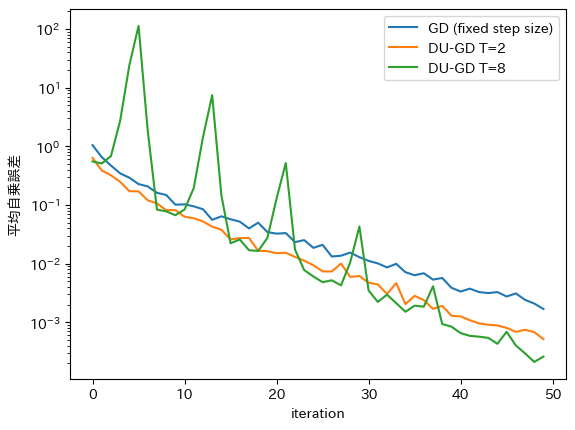

In [20]:
df.plot("iteration", ["GD (fixed step size)", "DU-GD T=2", "DU-GD T=8"])
plt.yscale("log")
plt.ylabel("平均自乗誤差");

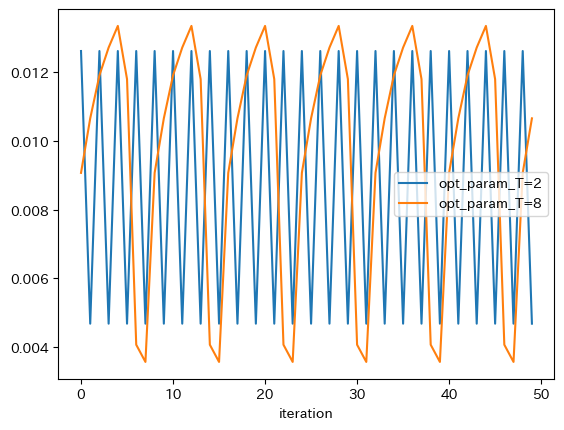

In [21]:
df.plot("iteration",["opt_param_T=2","opt_param_T=8"]);

- こっから下はDU-GD-LMS2の範囲

In [22]:
T = num_itr
eta_init = jnp.zeros(num_itr)
eta_trained = train(eta_init, T)

  0%|          | 0/50 [00:00<?, ?it/s]

loss:0.00027314850012771785 

In [23]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, T) for i in range(num_itr)]
df["non_cyclically_DU-GD".format(T)] = np.array(DUGD_mse)
df["non_cyclically_opt_param".format(T)] = [float(eta_trained[i%T]) for i in range(num_itr)]

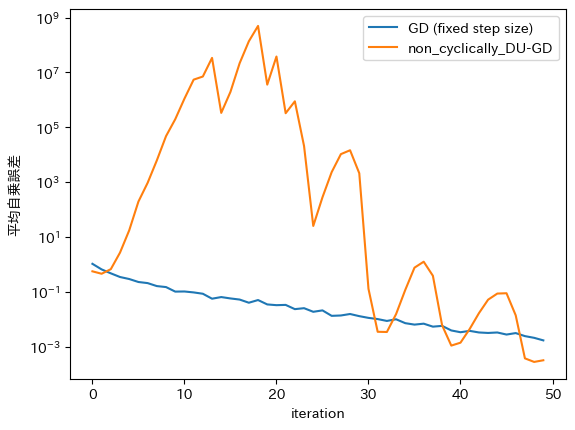

In [24]:
df.plot("iteration", ["GD (fixed step size)", "non_cyclically_DU-GD"])
plt.yscale("log")
plt.ylabel("平均自乗誤差");

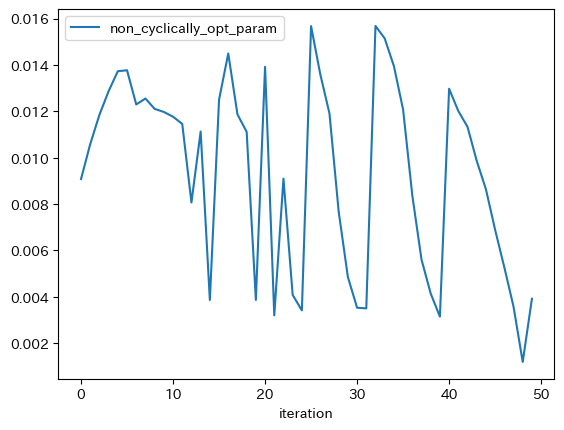

In [25]:
df.plot("iteration","non_cyclically_opt_param");